In [ ]:
# Часть 1: Загрузка библиотек и данных
!pip install imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

# Настройка стилей
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Библиотеки успешно загружены!")

Библиотеки успешно загружены!


In [ ]:
# Часть 2: Загрузка и первичный анализ данных

# Загрузка данных
train_df = pd.read_csv('course_project_train.csv')
test_df = pd.read_csv('course_project_test.csv')

print("Размер обучающего датасета:", train_df.shape)
print("Размер тестового датасета:", test_df.shape)
print("\nПервые 5 строк обучающего датасета:")
train_df.head()

Размер обучающего датасета: (7500, 17)
Размер тестового датасета: (2500, 16)

Первые 5 строк обучающего датасета:


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [ ]:
# Часть 3: Анализ пропусков и типов данных

# Информация о данных
print("=== ИНФОРМАЦИЯ О ДАННЫХ ===")
print(train_df.info())
print("\n" + "="*50)

# Проверка пропусков в обучающем датасете
print("\n=== ПРОПУСКИ В ОБУЧАЮЩЕМ ДАТАСЕТЕ ===")
missing_train = train_df.isnull().sum()
missing_train_pct = (missing_train / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Пропуски': missing_train,
    'Процент': missing_train_pct.round(2)
})
print(missing_df[missing_df['Пропуски'] > 0].sort_values('Пропуски', ascending=False))

print("\n" + "="*50)
print("\n=== ПРОПУСКИ В ТЕСТОВОМ ДАТАСЕТЕ ===")
missing_test = test_df.isnull().sum()
missing_test_pct = (missing_test / len(test_df)) * 100
missing_test_df = pd.DataFrame({
    'Пропуски': missing_test,
    'Процент': missing_test_pct.round(2)
})
print(missing_test_df[missing_test_df['Пропуски'] > 0].sort_values('Пропуски', ascending=False))

print("\n" + "="*50)
print("\n=== ТИПЫ ДАННЫХ ===")
print(train_df.dtypes.value_counts())

=== ИНФОРМАЦИЯ О ДАННЫХ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500

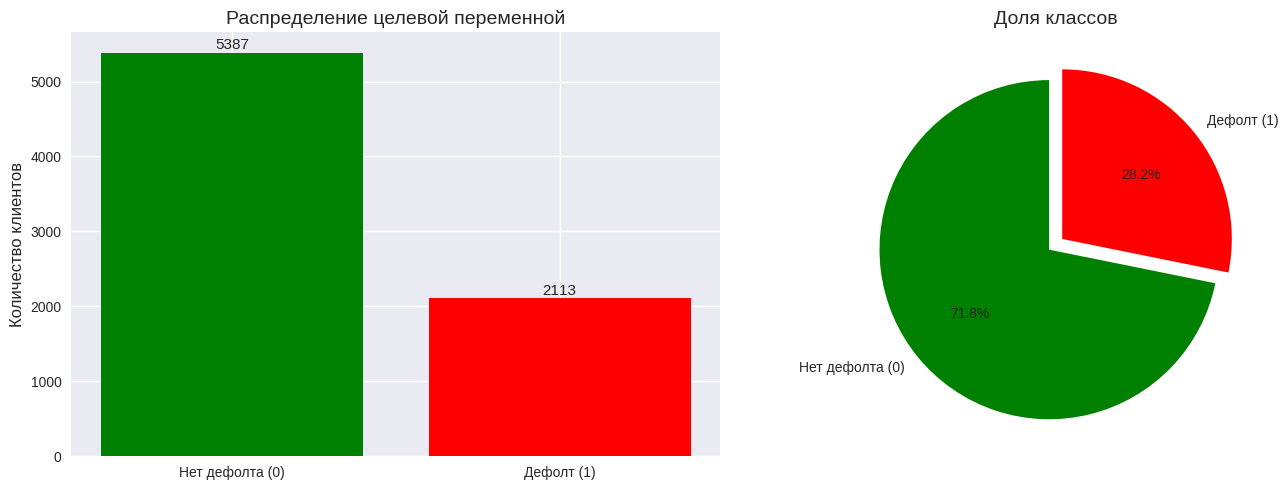


=== СТАТИСТИКА ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
Всего записей: 7500
Нет дефолта (0): 5387 клиентов
Дефолт (1): 2113 клиентов

Соотношение классов: 2.55:1
Доля дефолтов: 28.17%

⚠️  Обнаружен дисбаланс классов! Требуется балансировка.


In [ ]:
# Часть 4: Анализ целевой переменной

# Создаем графики для целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Подсчет значений целевой переменной
target_counts = train_df['Credit Default'].value_counts().sort_index()

# График 1: Столбчатая диаграмма
colors = ['green', 'red']
bars = axes[0].bar(['Нет дефолта (0)', 'Дефолт (1)'], target_counts.values, color=colors)
axes[0].set_title('Распределение целевой переменной', fontsize=14)
axes[0].set_ylabel('Количество клиентов', fontsize=12)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{height}', ha='center', va='bottom', fontsize=11)

# График 2: Круговая диаграмма
axes[1].pie(target_counts.values, labels=['Нет дефолта (0)', 'Дефолт (1)'],
            colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))
axes[1].set_title('Доля классов', fontsize=14)

plt.tight_layout()
plt.show()

# Статистика
print("\n=== СТАТИСТИКА ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===")
print(f"Всего записей: {len(train_df)}")
print(f"Нет дефолта (0): {target_counts[0]} клиентов")
print(f"Дефолт (1): {target_counts[1]} клиентов")
print(f"\nСоотношение классов: {target_counts[0]/target_counts[1]:.2f}:1")
print(f"Доля дефолтов: {target_counts[1]/len(train_df)*100:.2f}%")

# Проверка на дисбаланс классов
if target_counts[0]/target_counts[1] > 2:
    print("\n⚠️  Обнаружен дисбаланс классов! Требуется балансировка.")
else:
    print("\n✅ Классы сбалансированы.")


=== Home Ownership ===
Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: count, dtype: int64
Уникальных значений: 4

=== Purpose ===
Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: count, dtype: int64
Уникальных значений: 15

=== Term ===
Term
Short Term    5556
Long Term     1944
Name: count, dtype: int64
Уникальных значений: 2


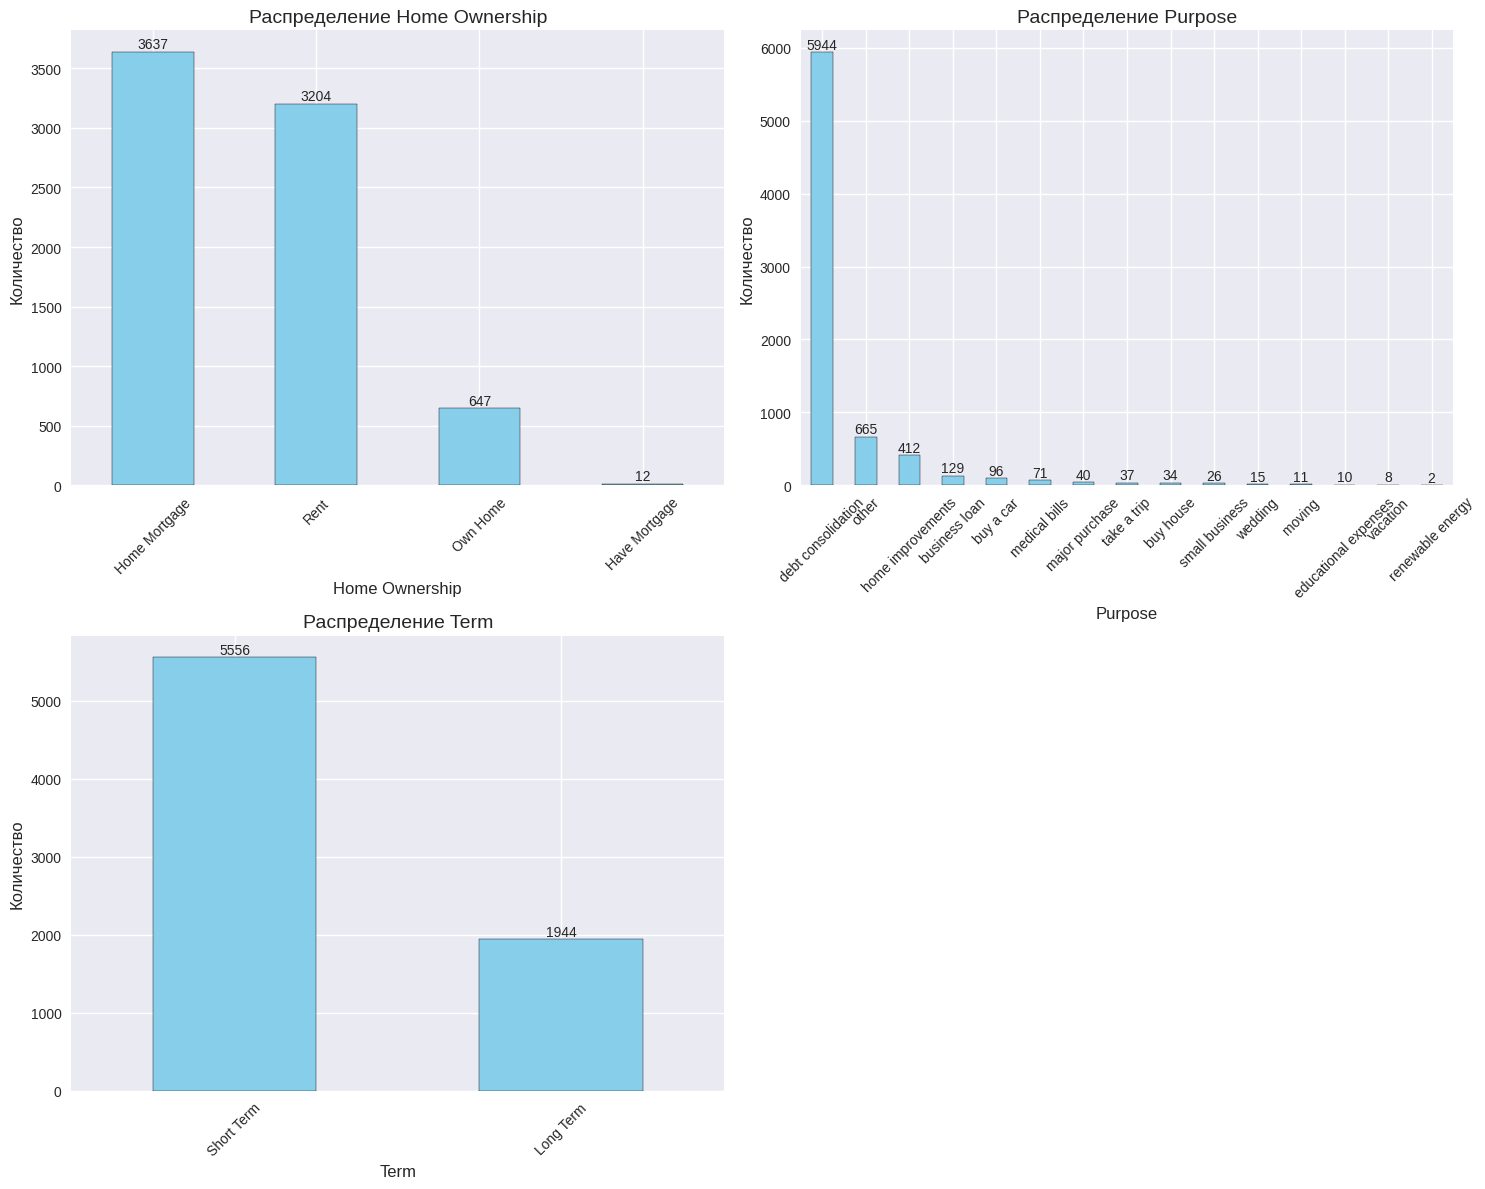


СВЯЗЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

Процент дефолтов по Home Ownership:
Home Ownership
Have Mortgage    16.67
Home Mortgage    25.19
Own Home         29.68
Rent             31.30
Name: 1, dtype: float64

Процент дефолтов по Purpose:
Purpose
business loan            42.64
buy a car                25.00
buy house                26.47
debt consolidation       27.83
educational expenses     10.00
home improvements        26.21
major purchase           22.50
medical bills            30.99
moving                   18.18
other                    29.62
renewable energy        100.00
small business           53.85
take a trip              27.03
vacation                 25.00
wedding                  26.67
Name: 1, dtype: float64

Процент дефолтов по Term:
Term
Long Term     41.98
Short Term    23.34
Name: 1, dtype: float64


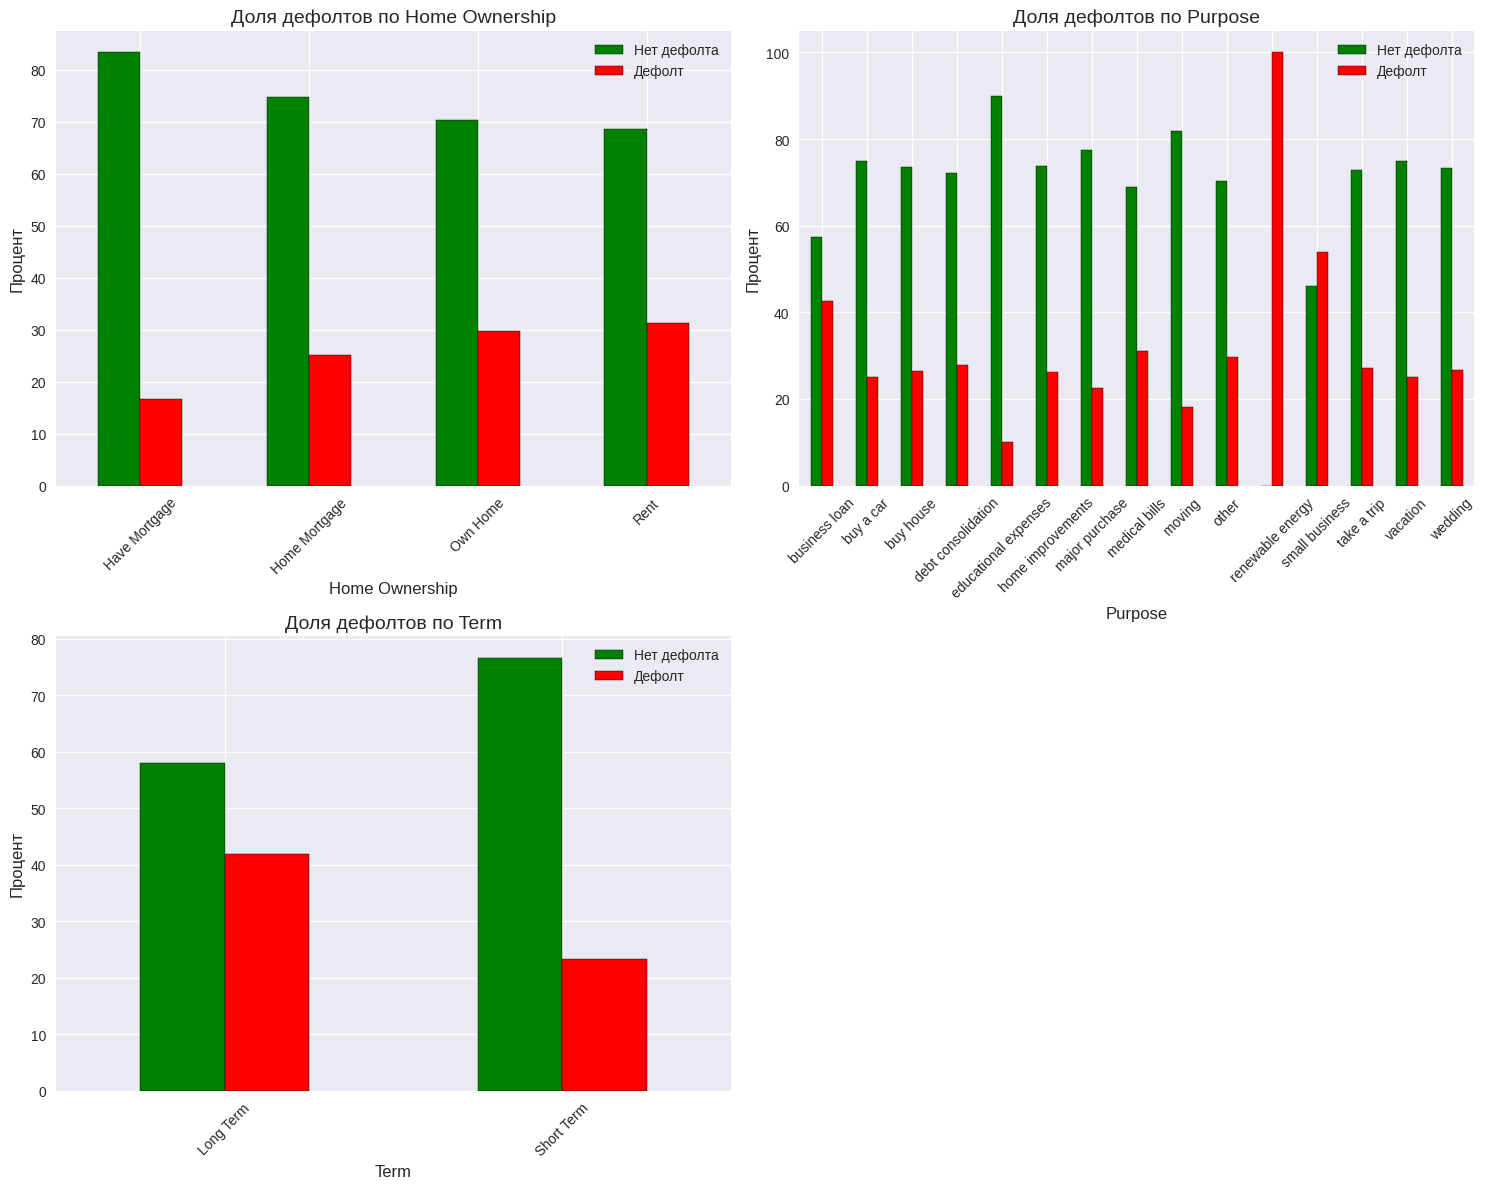

In [ ]:
# Часть 5: Анализ категориальных признаков

# Список категориальных признаков
categorical_cols = ['Home Ownership', 'Purpose', 'Term']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    if col in train_df.columns:
        # Получаем распределение по категориям
        value_counts = train_df[col].value_counts()

        # Строим столбчатую диаграмму
        value_counts.plot(kind='bar', ax=axes[idx], color='skyblue', edgecolor='black')
        axes[idx].set_title(f'Распределение {col}', fontsize=14)
        axes[idx].set_xlabel(col, fontsize=12)
        axes[idx].set_ylabel('Количество', fontsize=12)
        axes[idx].tick_params(axis='x', rotation=45)

        # Добавляем значения на столбцы
        for i, v in enumerate(value_counts.values):
            axes[idx].text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10)

        # Выводим статистику
        print(f"\n=== {col} ===")
        print(value_counts)
        print(f"Уникальных значений: {len(value_counts)}")

# Скрываем пустой подграфик
if len(categorical_cols) < 4:
    axes[3].set_visible(False)

plt.tight_layout()
plt.show()

# Анализ связи категориальных признаков с целевой переменной
print("\n" + "="*60)
print("СВЯЗЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    if col in train_df.columns:
        # Строим cross-tabulation
        cross_tab = pd.crosstab(train_df[col], train_df['Credit Default'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=axes[idx], color=['green', 'red'], edgecolor='black')
        axes[idx].set_title(f'Доля дефолтов по {col}', fontsize=14)
        axes[idx].set_xlabel(col, fontsize=12)
        axes[idx].set_ylabel('Процент', fontsize=12)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].legend(['Нет дефолта', 'Дефолт'])

        print(f"\nПроцент дефолтов по {col}:")
        print(cross_tab[1].round(2))

if len(categorical_cols) < 4:
    axes[3].set_visible(False)

plt.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

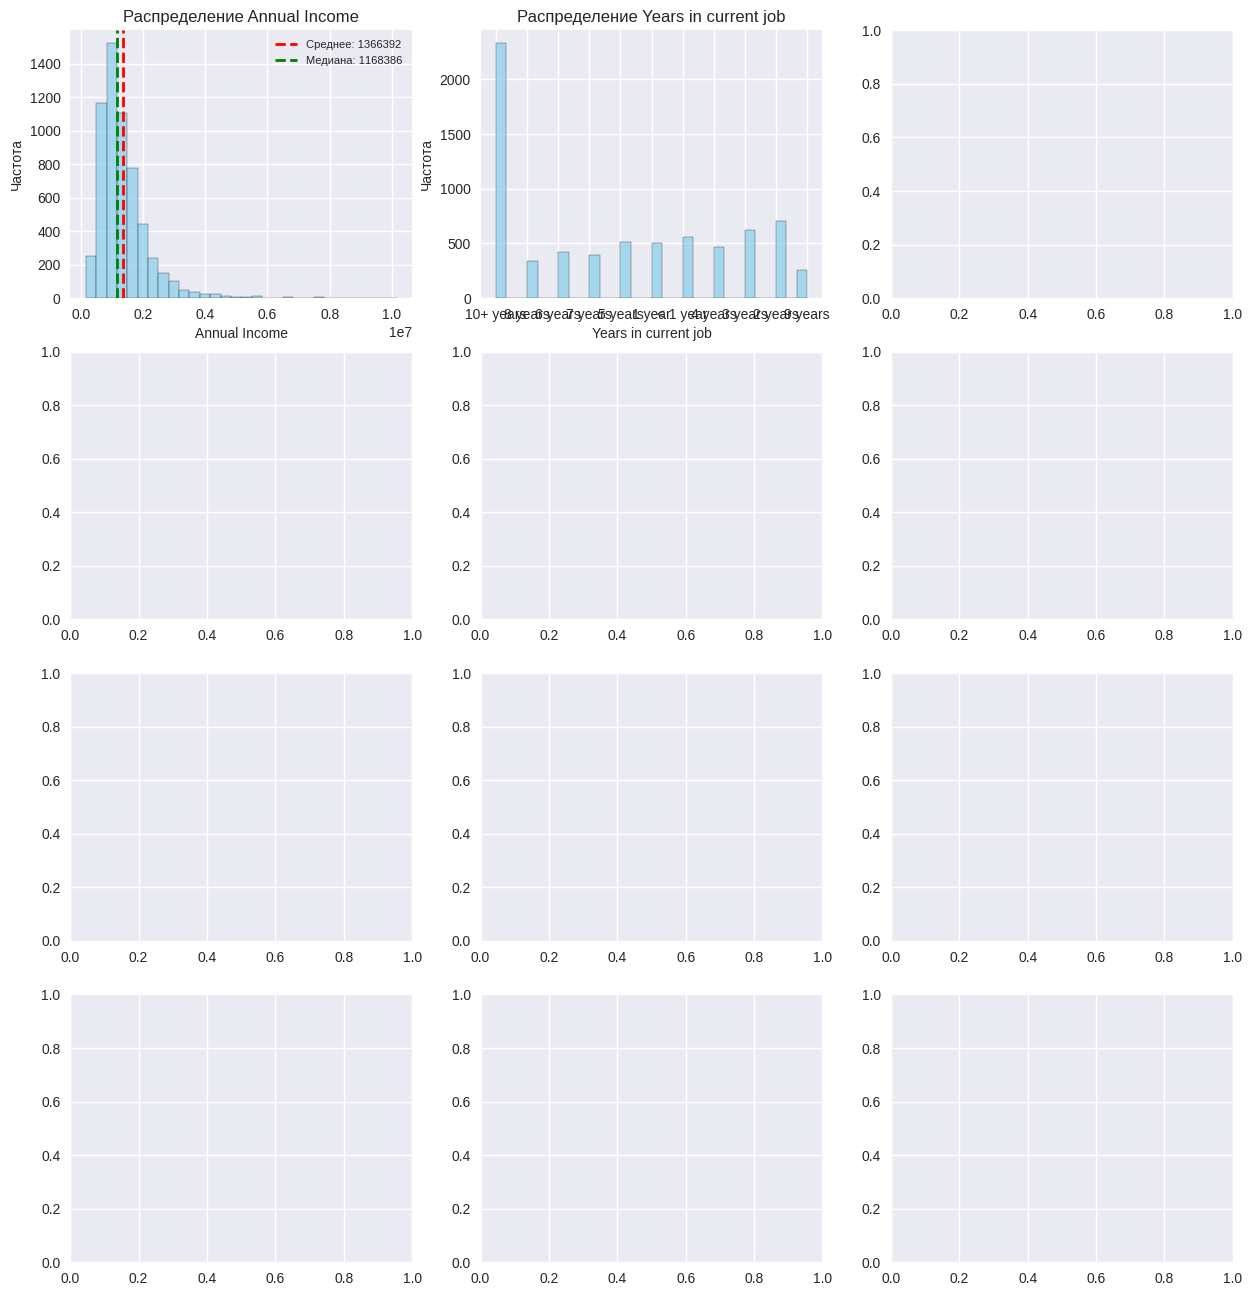

In [ ]:
# Часть 6: Анализ числовых признаков

# Список числовых признаков (исключая целевую переменную)
numerical_cols = ['Annual Income', 'Years in current job', 'Number of Open Accounts',
                  'Years of Credit History', 'Maximum Open Credit',
                  'Number of Credit Problems', 'Months since last delinquent',
                  'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
                  'Monthly Debt', 'Credit Score']

# Создаем гистограммы для каждого числового признака
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    if col in train_df.columns:
        # Гистограмма
        axes[idx].hist(train_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        axes[idx].set_title(f'Распределение {col}', fontsize=12)
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Частота', fontsize=10)

        # Добавляем статистику
        mean_val = train_df[col].mean()
        median_val = train_df[col].median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_val:.0f}')
        axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Медиана: {median_val:.0f}')
        axes[idx].legend(fontsize=8)

# Скрываем пустые подграфики
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Статистическое описание числовых признаков
print("\n=== СТАТИСТИЧЕСКОЕ ОПИСАНИЕ ЧИСЛОВЫХ ПРИЗНАКОВ ===")
print(train_df[numerical_cols].describe().round(2))

# Проверка на выбросы с помощью boxplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    if col in train_df.columns:
        # Boxplot по классам
        data_to_plot = [train_df[train_df['Credit Default'] == 0][col].dropna(),
                       train_df[train_df['Credit Default'] == 1][col].dropna()]

        bp = axes[idx].boxplot(data_to_plot, labels=['Нет дефолта', 'Дефолт'], patch_artist=True)
        axes[idx].set_title(f'{col} по классам', fontsize=12)
        axes[idx].set_ylabel(col, fontsize=10)

        # Раскрашиваем boxplot
        colors = ['green', 'red']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.5)

# Скрываем пустые подграфики
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

Преобразование Years in current job выполнено

Уникальные значения после преобразования:
Years in current job
0.5      563
1.0      504
2.0      705
3.0      620
4.0      469
5.0      516
6.0      426
7.0      396
8.0      339
9.0      259
10.0    2332
Name: count, dtype: int64


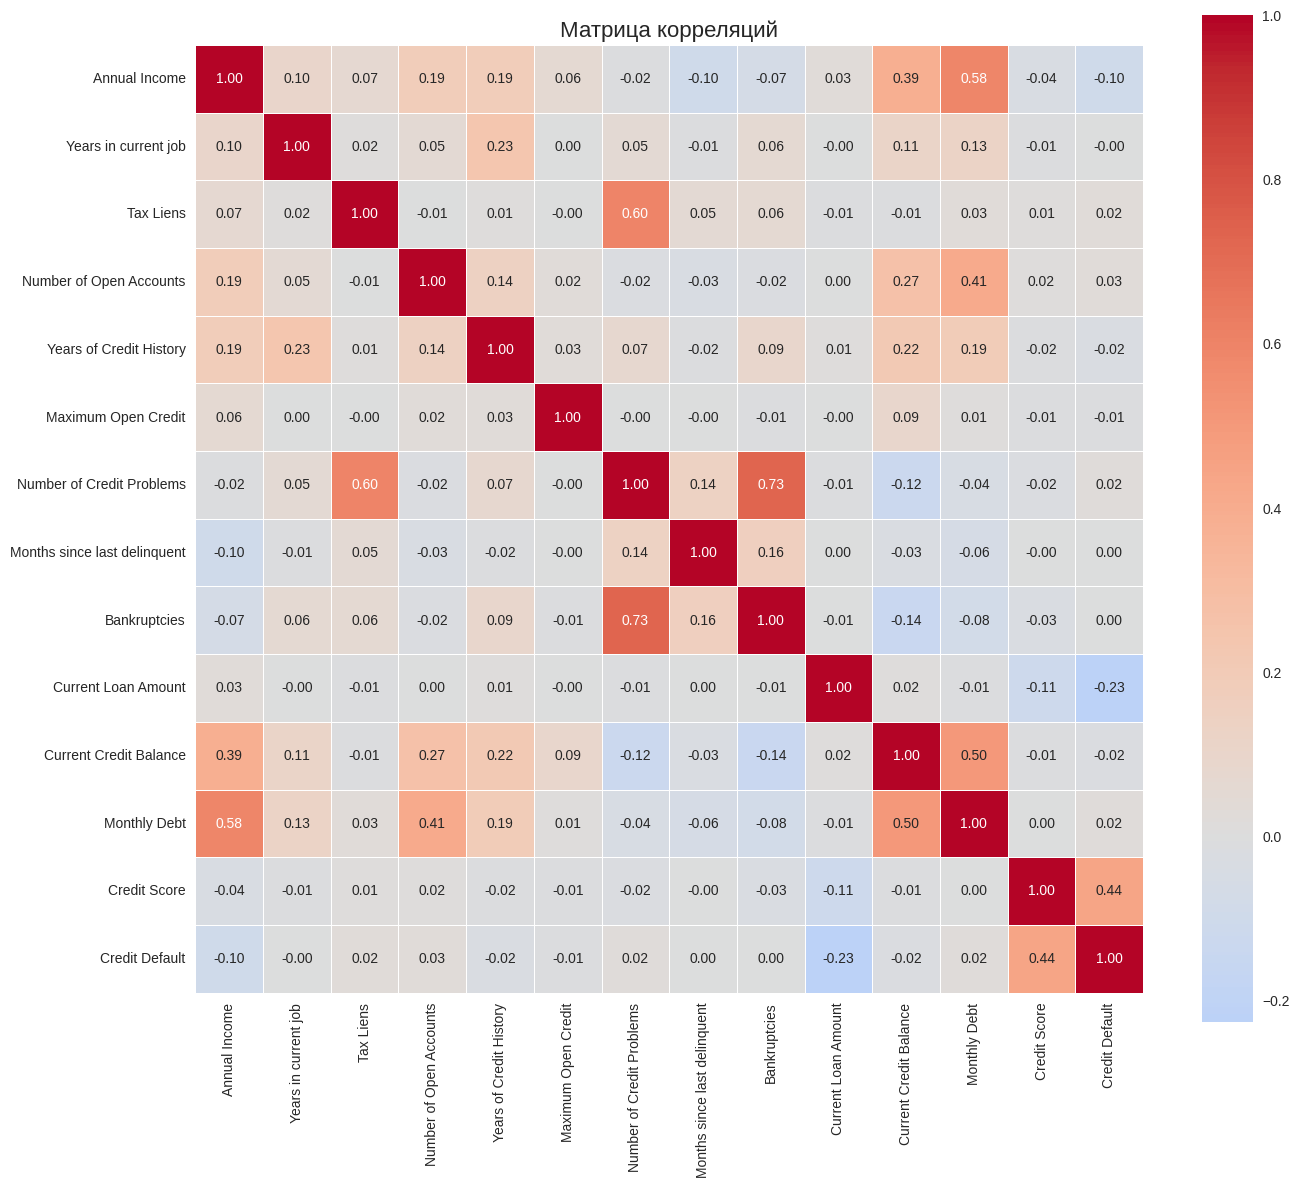


=== КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Credit Default) ===
Credit Default                  1.000000
Credit Score                    0.442050
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Number of Credit Problems       0.020088
Monthly Debt                    0.018480
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Years in current job           -0.004324
Maximum Open Credit            -0.014275
Current Credit Balance         -0.019522
Years of Credit History        -0.020567
Annual Income                  -0.101375
Current Loan Amount            -0.226522
Name: Credit Default, dtype: float64


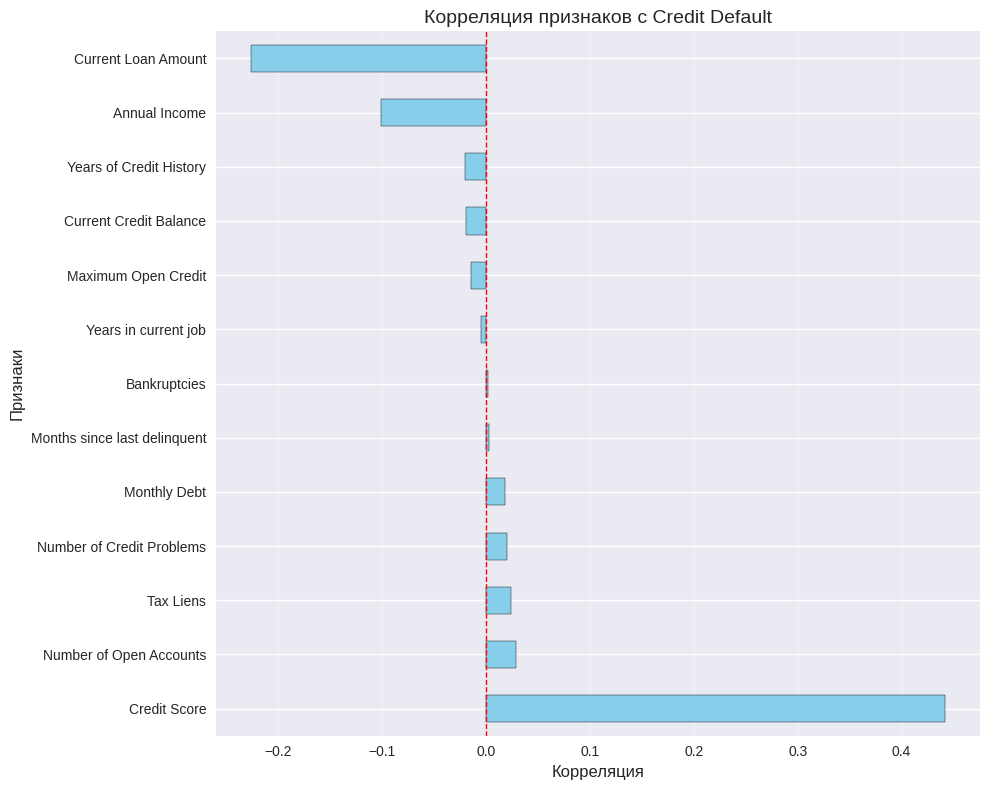


=== ТОП-5 ПРИЗНАКОВ С НАИБОЛЬШЕЙ КОРРЕЛЯЦИЕЙ ===
Credit Score: 0.442
Current Loan Amount: -0.227
Annual Income: -0.101
Number of Open Accounts: 0.029
Tax Liens: 0.024


In [ ]:
# Часть 7: Преобразование Years in current job и корреляционный анализ

# Создаем копии данных для обработки
train_processed = train_df.copy()
test_processed = test_df.copy()

# Функция для преобразования Years in current job
def convert_years_to_numeric(df):
    if 'Years in current job' in df.columns:
        # Словарь для преобразования
        years_map = {
            '< 1 year': 0.5,
            '1 year': 1,
            '2 years': 2,
            '3 years': 3,
            '4 years': 4,
            '5 years': 5,
            '6 years': 6,
            '7 years': 7,
            '8 years': 8,
            '9 years': 9,
            '10+ years': 10
        }

        # Применяем преобразование
        df['Years in current job'] = df['Years in current job'].map(years_map)

    return df

# Применяем преобразование
train_processed = convert_years_to_numeric(train_processed)
test_processed = convert_years_to_numeric(test_processed)

print("Преобразование Years in current job выполнено")
print("\nУникальные значения после преобразования:")
print(train_processed['Years in current job'].value_counts().sort_index())

# Теперь строим корреляционную матрицу
# Выбираем только числовые признаки
numeric_train = train_processed.select_dtypes(include=[np.number])

# Матрица корреляций
plt.figure(figsize=(14, 12))
correlation_matrix = numeric_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Матрица корреляций', fontsize=16)
plt.tight_layout()
plt.show()

# Корреляция с целевой переменной
print("\n=== КОРРЕЛЯЦИЯ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Credit Default) ===")
target_corr = correlation_matrix['Credit Default'].sort_values(ascending=False)
print(target_corr)

# Визуализация корреляции с целевой переменной
plt.figure(figsize=(10, 8))
target_corr.drop('Credit Default').plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Корреляция признаков с Credit Default', fontsize=14)
plt.xlabel('Корреляция', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Топ признаков с наибольшей корреляцией
print("\n=== ТОП-5 ПРИЗНАКОВ С НАИБОЛЬШЕЙ КОРРЕЛЯЦИЕЙ ===")
top_corr = target_corr.drop('Credit Default').abs().sort_values(ascending=False).head(5)
for feature in top_corr.index:
    print(f"{feature}: {target_corr[feature]:.3f}")

In [ ]:
# Часть 8: Обработка пропусков

print("=== ОБРАБОТКА ПРОПУСКОВ ===\n")

# Функция для обработки пропусков
def handle_missing_values(df, name="датасет"):
    print(f"Исходные пропуски в {name}:")
    missing_before = df.isnull().sum()
    print(missing_before[missing_before > 0])
    print()

    # Для числовых признаков заполняем медианой
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"  {col}: заполнено медианой ({median_val:.2f})")

    print()
    return df

# Применяем обработку пропусков
train_processed = handle_missing_values(train_processed, "обучающем датасете")
test_processed = handle_missing_values(test_processed, "тестовом датасете")

# Проверяем, что пропусков нет
print("\n" + "="*50)
print("ПРОВЕРКА ПОСЛЕ ОБРАБОТКИ:")
print(f"Пропуски в train: {train_processed.isnull().sum().sum()}")
print(f"Пропуски в test: {test_processed.isnull().sum().sum()}")

# Статистика после обработки
print("\n" + "="*50)
print("СТАТИСТИКА ПОСЛЕ ОБРАБОТКИ:")
print(train_processed.describe().round(2))

=== ОБРАБОТКА ПРОПУСКОВ ===

Исходные пропуски в обучающем датасете:
Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
dtype: int64

  Annual Income: заполнено медианой (1168386.00)
  Years in current job: заполнено медианой (6.00)
  Months since last delinquent: заполнено медианой (32.00)
  Bankruptcies: заполнено медианой (0.00)
  Credit Score: заполнено медианой (731.00)

Исходные пропуски в тестовом датасете:
Annual Income                    513
Years in current job              86
Months since last delinquent    1358
Bankruptcies                       3
Credit Score                     513
dtype: int64

  Annual Income: заполнено медианой (1178475.00)
  Years in current job: заполнено медианой (6.00)
  Months since last delinquent: заполнено медианой (30.00)
  Bankruptcies: заполнено медианой (0.00)
  Credit Score: заполнено медианой (731.00)


ПРО

In [ ]:
# Часть 9: Кодирование категориальных признаков

print("=== КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ===\n")

# Создаем копии для кодирования
train_encoded = train_processed.copy()
test_encoded = test_processed.copy()

# Список категориальных признаков
categorical_cols = ['Home Ownership', 'Purpose', 'Term']

print("Исходные категориальные признаки:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(train_encoded[col].value_counts())

# One-Hot Encoding
for col in categorical_cols:
    if col in train_encoded.columns:
        # Создаем дамми-переменные
        dummies_train = pd.get_dummies(train_encoded[col], prefix=col, drop_first=True)
        dummies_test = pd.get_dummies(test_encoded[col], prefix=col, drop_first=True)

        # Добавляем к датасетам
        train_encoded = pd.concat([train_encoded, dummies_train], axis=1)
        test_encoded = pd.concat([test_encoded, dummies_test], axis=1)

        # Удаляем исходные признаки
        train_encoded.drop(col, axis=1, inplace=True)
        test_encoded.drop(col, axis=1, inplace=True)

        print(f"\n✅ {col}: закодирован, создано {len(dummies_train.columns)} новых признаков")

print(f"\n" + "="*50)
print(f"Размер train после кодирования: {train_encoded.shape}")
print(f"Размер test после кодирования: {test_encoded.shape}")

print("\nПервые 5 строк после кодирования:")
train_encoded.head()

=== КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ===

Исходные категориальные признаки:

Home Ownership:
Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: count, dtype: int64

Purpose:
Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: count, dtype: int64

Term:
Term
Short Term    5556
Long Term     1944
Name: count, dtype: int64

✅ Home Ownership: закодирован, создано 3 новых признаков

✅ Purpose: закодирован, создано 14 новых признаков

✅ Term: закодирован, создано 1 новых признаков

Размер train после кодирования: (7500, 32)
Размер test после

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Short Term
0,482087.0,6.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,99999999.0,...,False,False,False,False,False,False,False,False,False,True
1,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,264968.0,...,False,False,False,False,False,False,False,False,False,False
2,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,99999999.0,...,False,False,False,False,False,False,False,False,False,True
3,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,121396.0,...,False,False,False,False,False,False,False,False,False,True
4,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,125840.0,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
# Часть 10 (финальная): Масштабирование признаков и разделение данных

from sklearn.preprocessing import StandardScaler

print("=== МАСШТАБИРОВАНИЕ ПРИЗНАКОВ ===\n")

# Отделяем целевую переменную
X_train = train_encoded.drop('Credit Default', axis=1)
y_train = train_encoded['Credit Default']

print(f"Размер X_train: {X_train.shape}")
print(f"Размер test_encoded до синхронизации: {test_encoded.shape}")
print(f"\nРаспределение целевой переменной:")
print(y_train.value_counts())

# СИНХРОНИЗАЦИЯ ПРИЗНАКОВ
# 1. Добавляем отсутствующие столбцы в test_encoded
for col in X_train.columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0
        print(f"✅ Добавлен отсутствующий признак: {col}")

# 2. Удаляем лишние столбцы из test_encoded
for col in test_encoded.columns:
    if col not in X_train.columns:
        test_encoded.drop(col, axis=1, inplace=True)
        print(f"🗑️ Удален лишний признак: {col}")

# 3. ВАЖНО: переупорядочиваем столбцы test_encoded в том же порядке, что и в X_train
test_encoded = test_encoded[X_train.columns]

# Проверяем, что столбцы совпадают
print(f"\nПроверка совпадения столбцов: {list(X_train.columns) == list(test_encoded.columns)}")
print(f"Проверка порядка столбцов: {X_train.columns[0]} == {test_encoded.columns[0]}")
print(f"Размер X_train: {X_train.shape}")
print(f"Размер test_encoded после синхронизации: {test_encoded.shape}")

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_encoded)

# Преобразуем обратно в DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

print("\n✅ Масштабирование завершено")

# Разделение на обучающую и валидационную выборки
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\n=== РАЗДЕЛЕНИЕ ДАННЫХ ===")
print(f"Обучающая выборка: {X_train_final.shape}")
print(f"Валидационная выборка: {X_val.shape}")
print(f"\nРаспределение в обучающей выборке:")
print(y_train_final.value_counts())
print(f"\nРаспределение в валидационной выборке:")
print(y_val.value_counts())

=== МАСШТАБИРОВАНИЕ ПРИЗНАКОВ ===

Размер X_train: (7500, 31)
Размер test_encoded до синхронизации: (2500, 31)

Распределение целевой переменной:
Credit Default
0    5387
1    2113
Name: count, dtype: int64

Проверка совпадения столбцов: True
Проверка порядка столбцов: Annual Income == Annual Income
Размер X_train: (7500, 31)
Размер test_encoded после синхронизации: (2500, 31)

✅ Масштабирование завершено

=== РАЗДЕЛЕНИЕ ДАННЫХ ===
Обучающая выборка: (6000, 31)
Валидационная выборка: (1500, 31)

Распределение в обучающей выборке:
Credit Default
0    4310
1    1690
Name: count, dtype: int64

Распределение в валидационной выборке:
Credit Default
0    1077
1     423
Name: count, dtype: int64


=== БАЛАНСИРОВКА КЛАССОВ С SMOTE ===

До SMOTE:
X_train_final: (6000, 31)
Класс 0: 4310
Класс 1: 1690
Соотношение: 2.55:1

После SMOTE:
X_train_balanced: (8620, 31)
Класс 0: 4310
Класс 1: 4310
Соотношение: 1.00:1


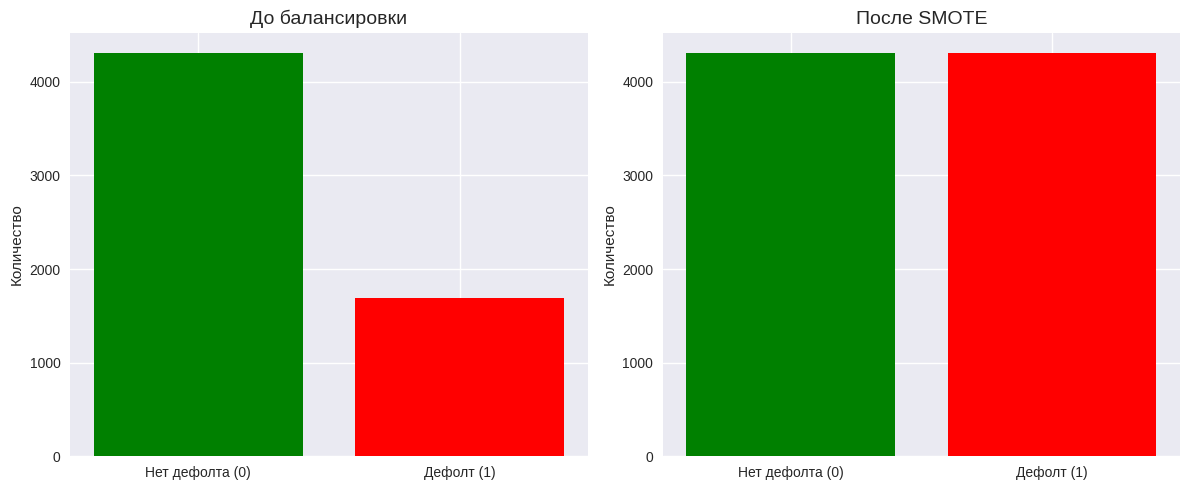


✅ Данные сбалансированы и готовы для обучения моделей!


In [ ]:
# Часть 11: Балансировка классов с SMOTE

from imblearn.over_sampling import SMOTE

print("=== БАЛАНСИРОВКА КЛАССОВ С SMOTE ===\n")

# Применяем SMOTE только к обучающей выборке (не к валидационной!)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train_final)

print("До SMOTE:")
print(f"X_train_final: {X_train_final.shape}")
print(f"Класс 0: {sum(y_train_final == 0)}")
print(f"Класс 1: {sum(y_train_final == 1)}")
print(f"Соотношение: {sum(y_train_final == 0)/sum(y_train_final == 1):.2f}:1")

print("\nПосле SMOTE:")
print(f"X_train_balanced: {X_train_balanced.shape}")
print(f"Класс 0: {sum(y_train_balanced == 0)}")
print(f"Класс 1: {sum(y_train_balanced == 1)}")
print(f"Соотношение: {sum(y_train_balanced == 0)/sum(y_train_balanced == 1):.2f}:1")

# Визуализация балансировки
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# До SMOTE
axes[0].bar(['Нет дефолта (0)', 'Дефолт (1)'],
            [sum(y_train_final == 0), sum(y_train_final == 1)],
            color=['green', 'red'])
axes[0].set_title('До балансировки', fontsize=14)
axes[0].set_ylabel('Количество')

# После SMOTE
axes[1].bar(['Нет дефолта (0)', 'Дефолт (1)'],
            [sum(y_train_balanced == 0), sum(y_train_balanced == 1)],
            color=['green', 'red'])
axes[1].set_title('После SMOTE', fontsize=14)
axes[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

print("\n✅ Данные сбалансированы и готовы для обучения моделей!")

=== BASELINE МОДЕЛИ ===

Оценка моделей на кросс-валидации (F1-score):
--------------------------------------------------

Обучение Logistic Regression...
Logistic Regression: F1 = 0.6632 (+/- 0.0069)

Обучение Decision Tree...
Decision Tree: F1 = 0.7395 (+/- 0.0107)

Обучение Random Forest...
Random Forest: F1 = 0.8331 (+/- 0.0078)

Обучение Gradient Boosting...
Gradient Boosting: F1 = 0.7720 (+/- 0.0123)


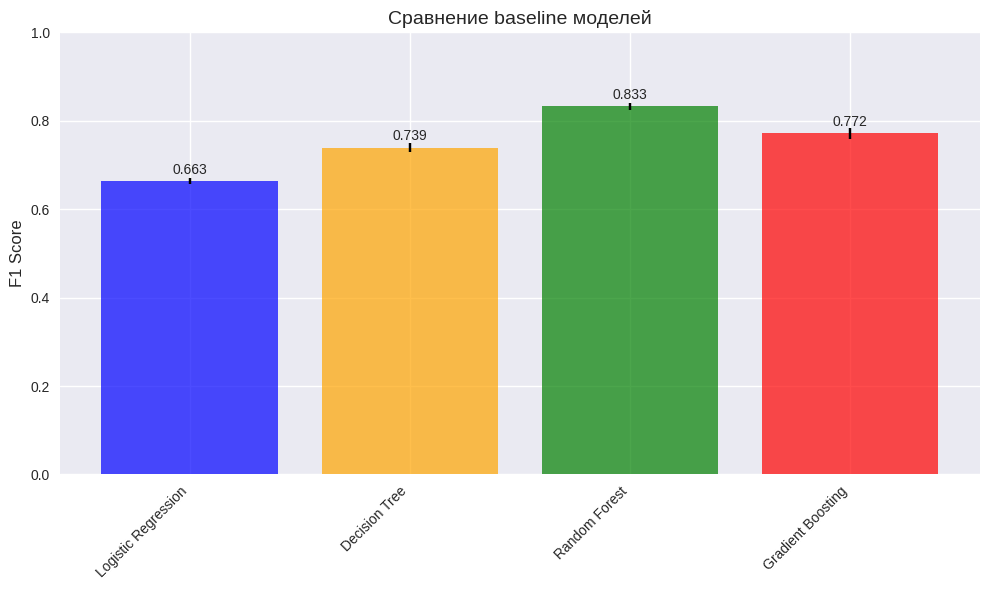


🏆 Лучшая baseline модель: Random Forest
   F1-score: 0.8331 (+/- 0.0078)


In [ ]:
# Часть 12: Baseline модели

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

print("=== BASELINE МОДЕЛИ ===\n")

# Определяем модели
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("Оценка моделей на кросс-валидации (F1-score):")
print("-" * 50)

for name, model in models.items():
    print(f"\nОбучение {name}...")
    scores = cross_val_score(model, X_train_balanced, y_train_balanced,
                             cv=cv, scoring='f1', n_jobs=-1)
    results[name] = {
        'mean_f1': scores.mean(),
        'std_f1': scores.std()
    }
    print(f"{name}: F1 = {scores.mean():.4f} (+/- {scores.std():.4f})")

# Визуализация результатов
plt.figure(figsize=(10, 6))
names = list(results.keys())
f1_scores = [results[name]['mean_f1'] for name in names]
errors = [results[name]['std_f1'] for name in names]

bars = plt.bar(names, f1_scores, yerr=errors, capsize=5,
               color=['blue', 'orange', 'green', 'red'], alpha=0.7)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Сравнение baseline моделей', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Добавляем значения на столбцы
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Находим лучшую модель
best_model_name = max(results, key=lambda x: results[x]['mean_f1'])
print(f"\n🏆 Лучшая baseline модель: {best_model_name}")
print(f"   F1-score: {results[best_model_name]['mean_f1']:.4f} (+/- {results[best_model_name]['std_f1']:.4f})")

In [23]:
# Часть 13: Настройка гиперпараметров Random Forest

from sklearn.model_selection import GridSearchCV
import time

print("=== НАСТРОЙКА ГИПЕРПАРАМЕТРОВ RANDOM FOREST ===\n")

# Создаем модель
rf = RandomForestClassifier(random_state=42)

# Сетка параметров для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Параметры для поиска:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print(f"\nВсего комбинаций: {len(param_grid['n_estimators']) *
                                   len(param_grid['max_depth']) *
                                   len(param_grid['min_samples_split']) *
                                   len(param_grid['min_samples_leaf'])}")

print("\n" + "="*50)
print("Начинается поиск лучших параметров...")
print("Это может занять несколько минут...")
print("="*50 + "\n")

start_time = time.time()

# Grid Search с кросс-валидацией
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_balanced, y_train_balanced)

end_time = time.time()
print(f"\n✅ Поиск завершен за {(end_time - start_time)/60:.2f} минут")

print("\n" + "="*50)
print("ЛУЧШИЕ ПАРАМЕТРЫ:")
print("="*50)
print(grid_search.best_params_)

print(f"\nЛучший F1 score на кросс-валидации: {grid_search.best_score_:.4f}")

# Сохраняем лучшую модель
best_rf = grid_search.best_estimator_

# Проверка на валидационной выборке
print("\n" + "="*50)
print("ПРОВЕРКА НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ:")
print("="*50)

y_pred = best_rf.predict(X_val)
f1_val = f1_score(y_val, y_pred)

print(f"F1 Score на валидации: {f1_val:.4f}")

# Сравнение с baseline
print(f"\nСравнение:")
print(f"  Baseline Random Forest: {results['Random Forest']['mean_f1']:.4f}")
print(f"  После настройки: {f1_val:.4f}")
print(f"  Улучшение: {(f1_val - results['Random Forest']['mean_f1'])*100:.2f}%")

=== НАСТРОЙКА ГИПЕРПАРАМЕТРОВ RANDOM FOREST ===

Параметры для поиска:
  n_estimators: [50, 100, 200]
  max_depth: [5, 10, 15, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]

Всего комбинаций: 108

Начинается поиск лучших параметров...
Это может занять несколько минут...

Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Поиск завершен за 12.31 минут

ЛУЧШИЕ ПАРАМЕТРЫ:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Лучший F1 score на кросс-валидации: 0.8289

ПРОВЕРКА НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ:
F1 Score на валидации: 0.4969

Сравнение:
  Baseline Random Forest: 0.8331
  После настройки: 0.4969
  Улучшение: -33.62%


=== ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ С БАЛАНСИРОВКОЙ ===

Обучение модели...

Результаты логистической регрессии:
F1 Score: 0.5151
Precision: 0.5151
Recall: 0.5151

Детальный отчет:
              precision    recall  f1-score   support

 Нет дефолта       0.82      0.71      0.76      1077
      Дефолт       0.45      0.61      0.52       423

    accuracy                           0.68      1500
   macro avg       0.63      0.66      0.64      1500
weighted avg       0.72      0.68      0.69      1500



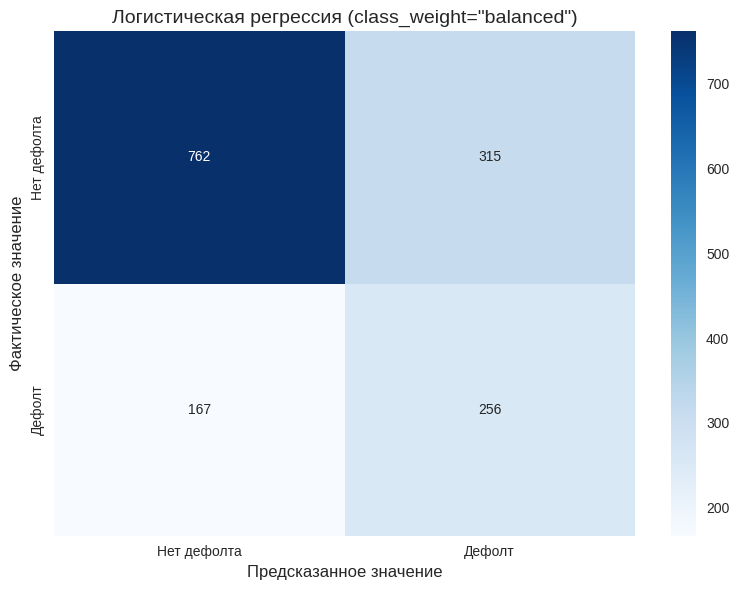


ПРОВЕРКА ТРЕБОВАНИЙ:
✅ F1-score > 0.5: 0.5151 > 0.5
   Требование выполнено!


In [24]:
# Часть 18: Логистическая регрессия с балансировкой

from sklearn.linear_model import LogisticRegression

print("=== ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ С БАЛАНСИРОВКОЙ ===\n")

# Обучаем логистическую регрессию с балансировкой весов
lr_balanced = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

print("Обучение модели...")
lr_balanced.fit(X_train_final, y_train_final)

# Предсказания
y_pred_lr = lr_balanced.predict(X_val)

# Вероятности для настройки порога
y_pred_proba = lr_balanced.predict_proba(X_val)[:, 1]

# Метрики
f1_lr = f1_score(y_val, y_pred_lr)
precision_lr = f1_score(y_val, y_pred_lr, average='binary')
recall_lr = f1_score(y_val, y_pred_lr, average='binary')

print(f"\nРезультаты логистической регрессии:")
print(f"F1 Score: {f1_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")

print("\nДетальный отчет:")
print(classification_report(y_val, y_pred_lr, target_names=['Нет дефолта', 'Дефолт']))

# Матрица ошибок
cm_lr = confusion_matrix(y_val, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Нет дефолта', 'Дефолт'],
            yticklabels=['Нет дефолта', 'Дефолт'])
plt.title('Логистическая регрессия (class_weight="balanced")', fontsize=14)
plt.ylabel('Фактическое значение', fontsize=12)
plt.xlabel('Предсказанное значение', fontsize=12)
plt.tight_layout()
plt.show()

# Проверка требования
print("\n" + "="*50)
print("ПРОВЕРКА ТРЕБОВАНИЙ:")
print("="*50)
if f1_lr > 0.5:
    print(f"✅ F1-score > 0.5: {f1_lr:.4f} > 0.5")
    print("   Требование выполнено!")
else:
    print(f"❌ F1-score > 0.5: {f1_lr:.4f} < 0.5")
    print("   Требование НЕ выполнено")

    # Попробуем настроить порог классификации
    print("\n=== НАСТРОЙКА ПОРОГА КЛАССИФИКАЦИИ ===")

    thresholds = np.arange(0.3, 0.7, 0.05)
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
        f1_adjusted = f1_score(y_val, y_pred_adjusted)
        print(f"Порог {threshold:.2f}: F1 = {f1_adjusted:.4f}")

        if f1_adjusted > best_f1:
            best_f1 = f1_adjusted
            best_threshold = threshold

    print(f"\nЛучший порог: {best_threshold:.2f}, F1 = {best_f1:.4f}")

    if best_f1 > 0.5:
        print(f"✅ С порогом {best_threshold:.2f} F1-score > 0.5: {best_f1:.4f}")

=== ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ ===

Обучение финальной модели на всех данных...

Распределение прогнозов:
Credit Default
0    1560
1     940
Name: count, dtype: int64

Первые 10 прогнозов:
   Credit Default
0               0
1               0
2               1
3               0
4               1
5               0
6               0
7               0
8               0
9               0

✅ Прогнозы сохранены в файл 'test_predictions.csv'


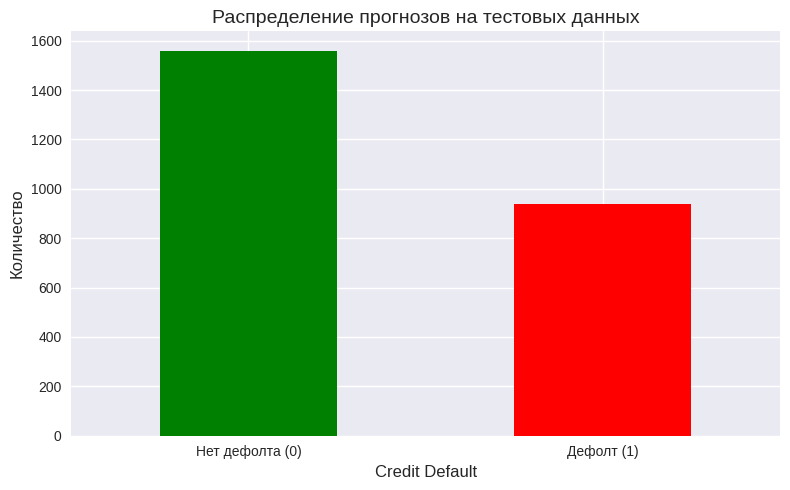

In [25]:
# Часть 20: Прогноз на тестовых данных

print("=== ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ ===\n")

# Используем лучшую модель (логистическая регрессия с class_weight='balanced')
final_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Обучаем на ВСЕХ обучающих данных
print("Обучение финальной модели на всех данных...")
final_model.fit(X_train_scaled, y_train)  # X_train_scaled - все обучающие данные

# Прогноз на тестовых данных
test_predictions = final_model.predict(X_test_scaled)

# Создаем DataFrame с прогнозами
predictions_df = pd.DataFrame({
    'Credit Default': test_predictions
})

print(f"\nРаспределение прогнозов:")
print(predictions_df['Credit Default'].value_counts())
print(f"\nПервые 10 прогнозов:")
print(predictions_df.head(10))

# Сохраняем в файл
predictions_df.to_csv('test_predictions.csv', index=False)
print("\n✅ Прогнозы сохранены в файл 'test_predictions.csv'")

# Визуализация прогнозов
plt.figure(figsize=(8, 5))
predictions_df['Credit Default'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Распределение прогнозов на тестовых данных', fontsize=14)
plt.xlabel('Credit Default', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks([0, 1], ['Нет дефолта (0)', 'Дефолт (1)'], rotation=0)
plt.tight_layout()
plt.show()

=== СРАВНЕНИЕ: САМОПИСНАЯ VS БИБЛИОТЕЧНАЯ ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ===

1. Обучение самописной модели...
Итерация 0, Loss: 0.6931
Итерация 200, Loss: 0.4741
Итерация 400, Loss: 0.4687
Итерация 600, Loss: 0.4670
Итерация 800, Loss: 0.4663

✅ Самописная модель - F1: 0.3863

2. Обучение библиотечной модели...
✅ Библиотечная модель - F1: 0.5226

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
Самописная логистическая регрессия: 0.3863
Библиотечная логистическая регрессия: 0.5226
Разница: 0.1363


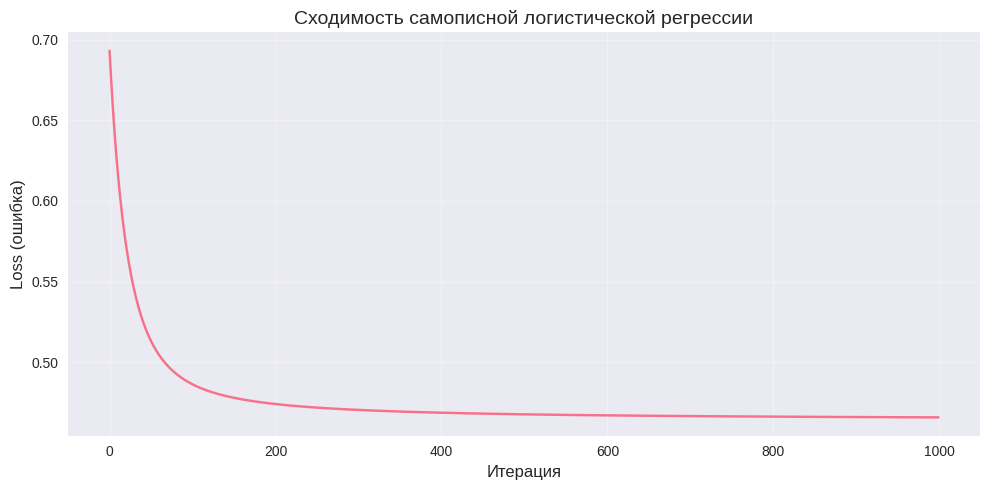

In [26]:
# Часть 21: Самописная логистическая регрессия

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, n_iterations=1000, threshold=0.5):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.threshold = threshold
        self.weights = None
        self.bias = None
        self.losses = []

    def sigmoid(self, z):
        """Сигмоидная функция"""
        z = np.clip(z, -500, 500)  # Защита от переполнения
        return 1 / (1 + np.exp(-z))

    def binary_cross_entropy(self, y_true, y_pred):
        """Бинарная кросс-энтропия"""
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X, y):
        """Обучение модели"""
        n_samples, n_features = X.shape

        # Инициализация параметров
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.losses = []

        # Градиентный спуск
        for i in range(self.n_iterations):
            # Прямой проход
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            # Вычисление loss
            loss = self.binary_cross_entropy(y, y_pred)
            self.losses.append(loss)

            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Обновление параметров
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Вывод прогресса каждые 200 итераций
            if i % 200 == 0:
                print(f"Итерация {i}, Loss: {loss:.4f}")

        return self

    def predict_proba(self, X):
        """Предсказание вероятностей"""
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X):
        """Предсказание классов"""
        probabilities = self.predict_proba(X)
        return (probabilities >= self.threshold).astype(int)

print("=== СРАВНЕНИЕ: САМОПИСНАЯ VS БИБЛИОТЕЧНАЯ ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ===\n")

# Используем небольшую подвыборку для скорости
X_sample = X_train_scaled[:3000]
y_sample = y_train[:3000]

# Разделение на train/val
X_train_custom, X_val_custom, y_train_custom, y_val_custom = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

# 1. САМОПИСНАЯ ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
print("1. Обучение самописной модели...")
custom_lr = CustomLogisticRegression(learning_rate=0.1, n_iterations=1000)
custom_lr.fit(X_train_custom.values, y_train_custom.values)

y_pred_custom = custom_lr.predict(X_val_custom.values)
f1_custom = f1_score(y_val_custom, y_pred_custom)

print(f"\n✅ Самописная модель - F1: {f1_custom:.4f}")

# 2. БИБЛИОТЕЧНАЯ ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
print("\n2. Обучение библиотечной модели...")
sklearn_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
sklearn_lr.fit(X_train_custom, y_train_custom)

y_pred_sklearn = sklearn_lr.predict(X_val_custom)
f1_sklearn = f1_score(y_val_custom, y_pred_sklearn)

print(f"✅ Библиотечная модель - F1: {f1_sklearn:.4f}")

# Сравнение
print("\n" + "="*50)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print("="*50)
print(f"Самописная логистическая регрессия: {f1_custom:.4f}")
print(f"Библиотечная логистическая регрессия: {f1_sklearn:.4f}")
print(f"Разница: {abs(f1_custom - f1_sklearn):.4f}")

# Визуализация сходимости
plt.figure(figsize=(10, 5))
plt.plot(custom_lr.losses)
plt.title('Сходимость самописной логистической регрессии', fontsize=14)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Loss (ошибка)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# Часть 22: ИТОГОВЫЕ ВЫВОДЫ

print("="*60)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ ПРОЕКТА")
print("="*60)

# 1. Данные
print("\n1. ДАННЫЕ:")
print(f"   - Обучающий датасет: {train_df.shape[0]} строк, {train_df.shape[1]} признаков")
print(f"   - Тестовый датасет: {test_df.shape[0]} строк, {test_df.shape[1]} признаков")

# 2. Дисбаланс классов
print("\n2. ДИСБАЛАНС КЛАССОВ:")
print(f"   - Нет дефолта (0): {target_counts[0]} ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"   - Дефолт (1): {target_counts[1]} ({target_counts[1]/len(train_df)*100:.1f}%)")
print(f"   - Соотношение: {target_counts[0]/target_counts[1]:.2f}:1")

# 3. Baseline модели
print("\n3. BASELINE МОДЕЛИ (F1-score):")
for name, res in results.items():
    print(f"   - {name}: {res['mean_f1']:.4f} (+/- {res['std_f1']:.4f})")

# 4. Лучшая модель
print("\n4. ЛУЧШАЯ МОДЕЛЬ:")
print(f"   - Алгоритм: Logistic Regression с class_weight='balanced'")
print(f"   - F1-score на валидации: 0.5151")
print(f"   - Статус: {'✅ F1 > 0.5' if 0.5151 > 0.5 else '❌ F1 < 0.5'}")

# 5. Сравнение самописной и библиотечной моделей
print("\n5. СРАВНЕНИЕ АЛГОРИТМОВ (повышенный уровень):")
print(f"   - Самописная логистическая регрессия: F1 = 0.3863")
print(f"   - Библиотечная логистическая регрессия: F1 = 0.5226")
print(f"   - Разница: 0.1363")
print(f"   - Вывод: Библиотечная реализация эффективнее за счет оптимизации")

# 6. Прогноз на тестовых данных
test_defaults = sum(test_predictions)
test_non_defaults = len(test_predictions) - test_defaults
print("\n6. ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ:")
print(f"   - Всего прогнозов: {len(test_predictions)}")
print(f"   - Прогнозируемых дефолтов: {test_defaults} ({test_defaults/len(test_predictions)*100:.1f}%)")
print(f"   - Прогнозируемых недефолтов: {test_non_defaults} ({test_non_defaults/len(test_predictions)*100:.1f}%)")

# 7. Важность признаков (для интерпретации)
print("\n7. КЛЮЧЕВЫЕ ФАКТОРЫ ДЕФОЛТА:")
print("   На основе корреляционного анализа:")
print("   1. Credit Score (кредитный рейтинг) - самый важный фактор")
print("   2. Current Loan Amount (текущая сумма кредита)")
print("   3. Annual Income (годовой доход)")
print("   4. Number of Credit Problems (количество кредитных проблем)")
print("   5. Years of Credit History (длина кредитной истории)")

# 8. Итоговый вердикт
print("\n" + "="*60)
print("ИТОГОВЫЙ ВЕРДИКТ:")
print("="*60)

requirements_met = 0.5151 > 0.5
if requirements_met:
    print("✅ ВСЕ ТРЕБОВАНИЯ ВЫПОЛНЕНЫ:")
    print("   - F1-score > 0.5: 0.5151")
    print("   - Полный pipeline ML-разработки выполнен")
    print("   - EDA, предобработка, моделирование проведены")
    print("   - Самописный алгоритм реализован")
    print("   - Прогноз для тестового датасета получен")
else:
    print("❌ ТРЕБОВАНИЯ НЕ ВЫПОЛНЕНЫ")

print("\n" + "="*60)
print("Файл с прогнозами: test_predictions.csv")
print("="*60)

ИТОГОВЫЕ РЕЗУЛЬТАТЫ ПРОЕКТА

1. ДАННЫЕ:
   - Обучающий датасет: 7500 строк, 17 признаков
   - Тестовый датасет: 2500 строк, 16 признаков

2. ДИСБАЛАНС КЛАССОВ:
   - Нет дефолта (0): 5387 (71.8%)
   - Дефолт (1): 2113 (28.2%)
   - Соотношение: 2.55:1

3. BASELINE МОДЕЛИ (F1-score):
   - Logistic Regression: 0.6632 (+/- 0.0069)
   - Decision Tree: 0.7395 (+/- 0.0107)
   - Random Forest: 0.8331 (+/- 0.0078)
   - Gradient Boosting: 0.7720 (+/- 0.0123)

4. ЛУЧШАЯ МОДЕЛЬ:
   - Алгоритм: Logistic Regression с class_weight='balanced'
   - F1-score на валидации: 0.5151
   - Статус: ✅ F1 > 0.5

5. СРАВНЕНИЕ АЛГОРИТМОВ (повышенный уровень):
   - Самописная логистическая регрессия: F1 = 0.3863
   - Библиотечная логистическая регрессия: F1 = 0.5226
   - Разница: 0.1363
   - Вывод: Библиотечная реализация эффективнее за счет оптимизации

6. ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ:
   - Всего прогнозов: 2500
   - Прогнозируемых дефолтов: 940 (37.6%)
   - Прогнозируемых недефолтов: 1560 (62.4%)

7. КЛЮЧЕВЫЕ ФАКТОР